# Fetal Health Classification

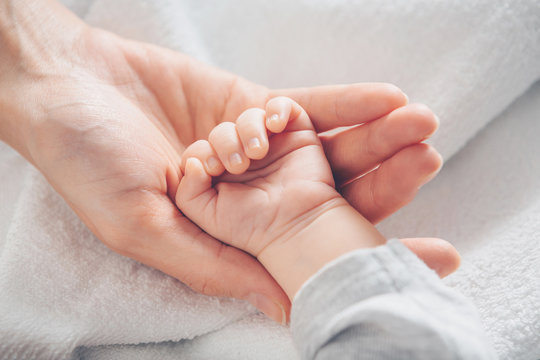

# **Overview:**

Here we'll attempt to create machine learning models able to classify different fetal Cardiotocograms (CTGs) into one of three different classes: Normal, Suspect, or Pathological. 

Cardiotocograms are continuous recordings of fetal heart rate and uterine contractions during pregnancy and labour taken by ultrasound transducer placed on a mother's abdomen. 

The researchers who created this dataset did a very thorough job preprocessing and generating useful statistics with their data, and this is an excellent dataset to test the performance of different machine learning models using numerical features. 

The sections in this Notebook are as follows:
1. Overview
2. Exploratory Data Analysis
    * Initial Correlation Analysis
3. Prepocessing
    * Feature Scaling
4. Modeling
    * Cross-Validation
    * Grid Search Cross-Validation
        * RandomForestClassifier
        * KNeighborsClassifier
        * SVC
    * Saving
5. Conclusions

See citation below for a discussion of the methodologies used in gathering this dataset.
> Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318 [(link)](https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)

# **Exploratory Data Analysis**

In [73]:
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

In [74]:
# Read the dataset into a DataFrame
fetal_data = pd.read_csv('/kaggle/input/fetal-health-classification/fetal_health.csv')

In [75]:
# We'll check to make sure the data loaded properly
fetal_data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [76]:
# Check the shape of our dataset
fetal_data.shape

(2126, 22)

In [77]:
# Let's look and see if there are any missing values within this dataset
fetal_data.isnull().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

Beautiful - the researchers did an incredibly thorough job collecting and prepocessing their data. 

Note that at this stage, we would usually determine a strategy for dealing with missing values in our dataset, as well as mapping any categorical features to numerical values as appropriate.

# Initial correlation analysis:

In [78]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('dark')

In [79]:
# Let's take a look at the correlations between columns in our dataset,
# specifically focusing on our target class variable.
fetal_data.corr()['fetal_health']

baseline value                                            0.148151
accelerations                                            -0.364066
fetal_movement                                            0.088010
uterine_contractions                                     -0.204894
light_decelerations                                       0.058870
severe_decelerations                                      0.131934
prolongued_decelerations                                  0.484859
abnormal_short_term_variability                           0.471191
mean_value_of_short_term_variability                     -0.103382
percentage_of_time_with_abnormal_long_term_variability    0.426146
mean_value_of_long_term_variability                      -0.226797
histogram_width                                          -0.068789
histogram_min                                             0.063175
histogram_max                                            -0.045265
histogram_number_of_peaks                                -0.02

Negative correlations here indicate that when our feature drops in value, our fetal_health variable tends to increase in value. Because our fetal_health variable is ordinally encoded as Normal = 1.0, Suspect = 2.0, and Pathological = 3.0, we can correctly interpret this as a drop in these features seems to contribute to a decline in fetal health outcomes. Consequently, increases in these features' values might be considered protective. **A feature with negative correlation to fetal_health in this dataset that we might want to look at is accelerations (r = -0.364).**

**Additionally, there are three features with moderate positive correlations with fetal_health: prolonged_decelerations (r = 0.485), abnormal_short_term_variability (r = 0.471), and percentage_of_time_with_abnormal_long_term_variability (r = 0.426).** When these features increase in value, our fetal_health variable tends to increase as well, and this indicates that they might be valuable in predicting negative health outcomes.

Of course, the fetal_health column correlates perfectly with itself, and this is a nice check to make sure our simple correlation analysis ran correctly. For those who are extra conscientious, we would see the same pattern diagonally across our correlation matrix, and any abnormality in this pattern would indicate some underlying aberration in our data.

We'll visualize our highest positive correlation and negative correlation using simple regression analyses to futher build an intuition.

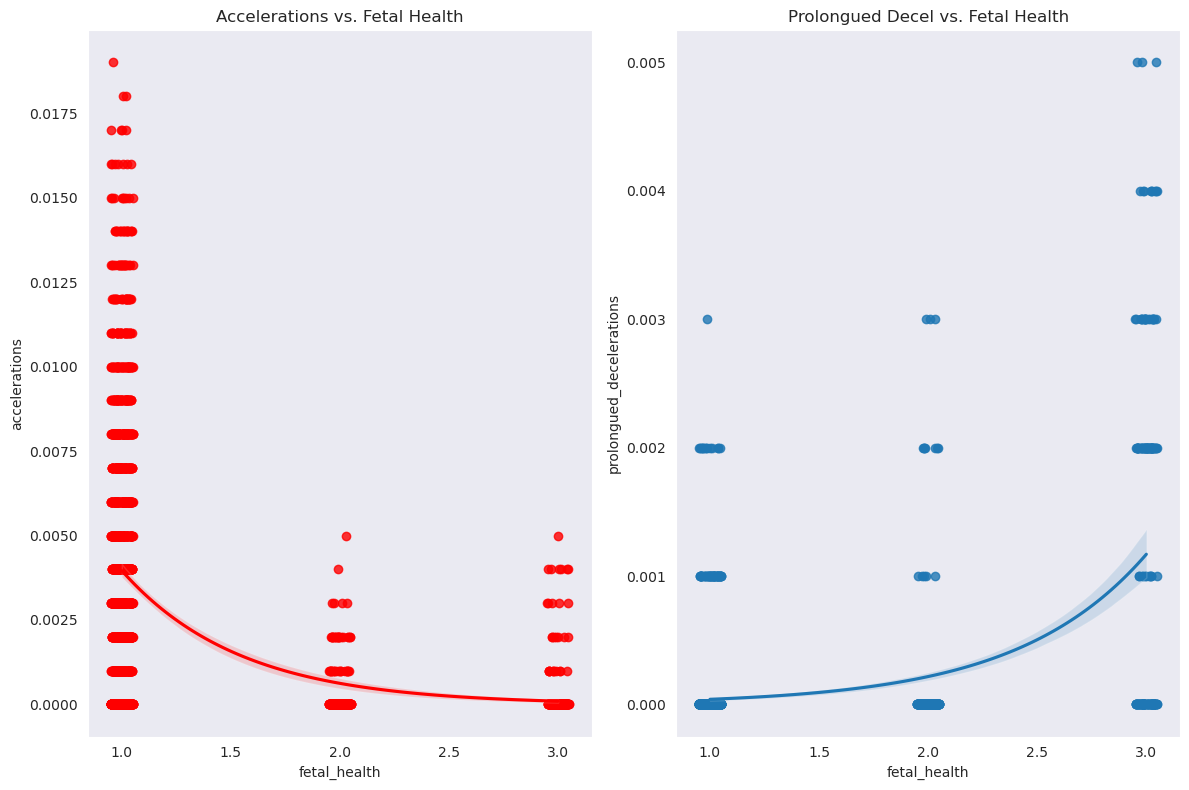

Sample size: 2126


In [80]:
# Pull our dataframes and construct our figure and subplots
neg_cor = fetal_data[['accelerations', 'fetal_health']]
pos_cor = fetal_data[['prolongued_decelerations', 'fetal_health']]
fig, axs = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1]))

# Plot each regression analysis
acc = sns.regplot(data=neg_cor, x='fetal_health', y='accelerations', logistic=True, 
                  x_jitter=.05, color='red', ax=axs[0])
pro_dec = sns.regplot(data=pos_cor[['prolongued_decelerations', 'fetal_health']], 
                     x='fetal_health', y='prolongued_decelerations', logistic=True, x_jitter=.05, ax=axs[1])

# Titles for each subplot
axs[0].set_title("Accelerations vs. Fetal Health")
axs[1].set_title("Prolongued Decel vs. Fetal Health")
fig.tight_layout()
plt.show()

print(f'Sample size: {fetal_data.shape[0]}')

# **Preprocessing**

In [81]:
# First we'll extract the features we want to use for prediction in our dataset
X = fetal_data.drop('fetal_health', axis=1)

# We'll take a high level statistical overview of these numerical features
X.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


In [82]:
# Next, we'll extract our classification target
y = fetal_data['fetal_health']

# Let's look at the frequency of each class in this dataset
y.value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

[Text(0, 0, '1655'), Text(0, 0, '295'), Text(0, 0, '176')]

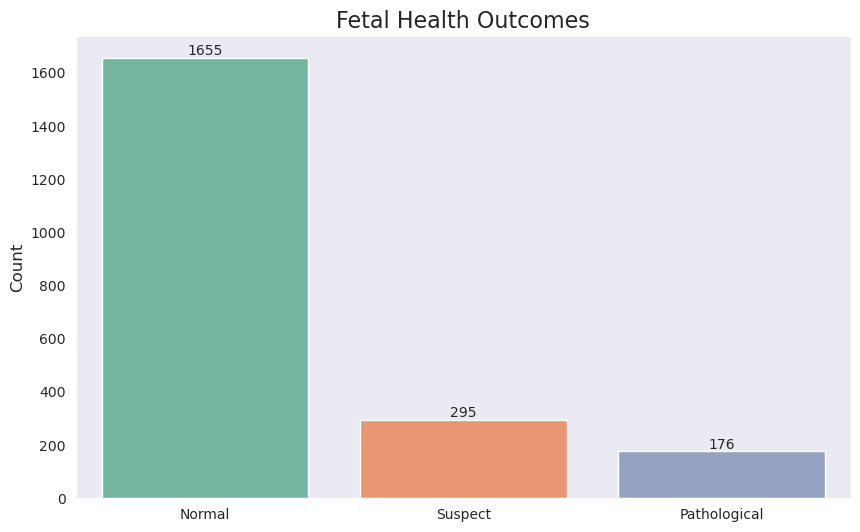

In [83]:
# Let's visualize our class
classes = ['Normal', 'Suspect', 'Pathological']

plt.figure(figsize=(10, 6))
fh = sns.barplot(x=classes, y=y.value_counts(), palette='Set2')

# Titles
plt.title('Fetal Health Outcomes', fontsize=16)
plt.ylabel('Count', fontsize=12)
fh.bar_label(fh.containers[0])

It looks like in this dataset 1655 birth events were categorized as Normal, 295 as Suspect, and 176 as Pathological by the expert obstetricians who collaborated with the research. We should note that there is an imbalance in our fetal_health class, which tends to produce misleading classification accuracy.

**Note that the researchers decided to use ordinal encoding for mapping their class variable to float values.** Here we are assuming that the numerical distances between each fetal health state are constant, and this is important to keep in mind because it can introduce bias into our modeling and distort the underlying relationships between our feature and class variables. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'baseline value'),
  Text(1, 0, 'accelerations'),
  Text(2, 0, 'fetal_movement'),
  Text(3, 0, 'uterine_contractions'),
  Text(4, 0, 'light_decelerations'),
  Text(5, 0, 'severe_decelerations'),
  Text(6, 0, 'prolongued_decelerations'),
  Text(7, 0, 'abnormal_short_term_variability'),
  Text(8, 0, 'mean_value_of_short_term_variability'),
  Text(9, 0, 'percentage_of_time_with_abnormal_long_term_variability'),
  Text(10, 0, 'mean_value_of_long_term_variability'),
  Text(11, 0, 'histogram_width'),
  Text(12, 0, 'histogram_min'),
  Text(13, 0, 'histogram_max'),
  Text(14, 0, 'histogram_number_of_peaks'),
  Text(15, 0, 'histogram_number_of_zeroes'),
  Text(16, 0, 'histogram_mode'),
  Text(17, 0, 'histogram_mean'),
  Text(18, 0, 'histogram_median'),
  Text(19, 0, 'histogram_variance'),
  Text(20, 0, 'histogram_tendency'),
  Text(21, 0, 'fetal_health')])

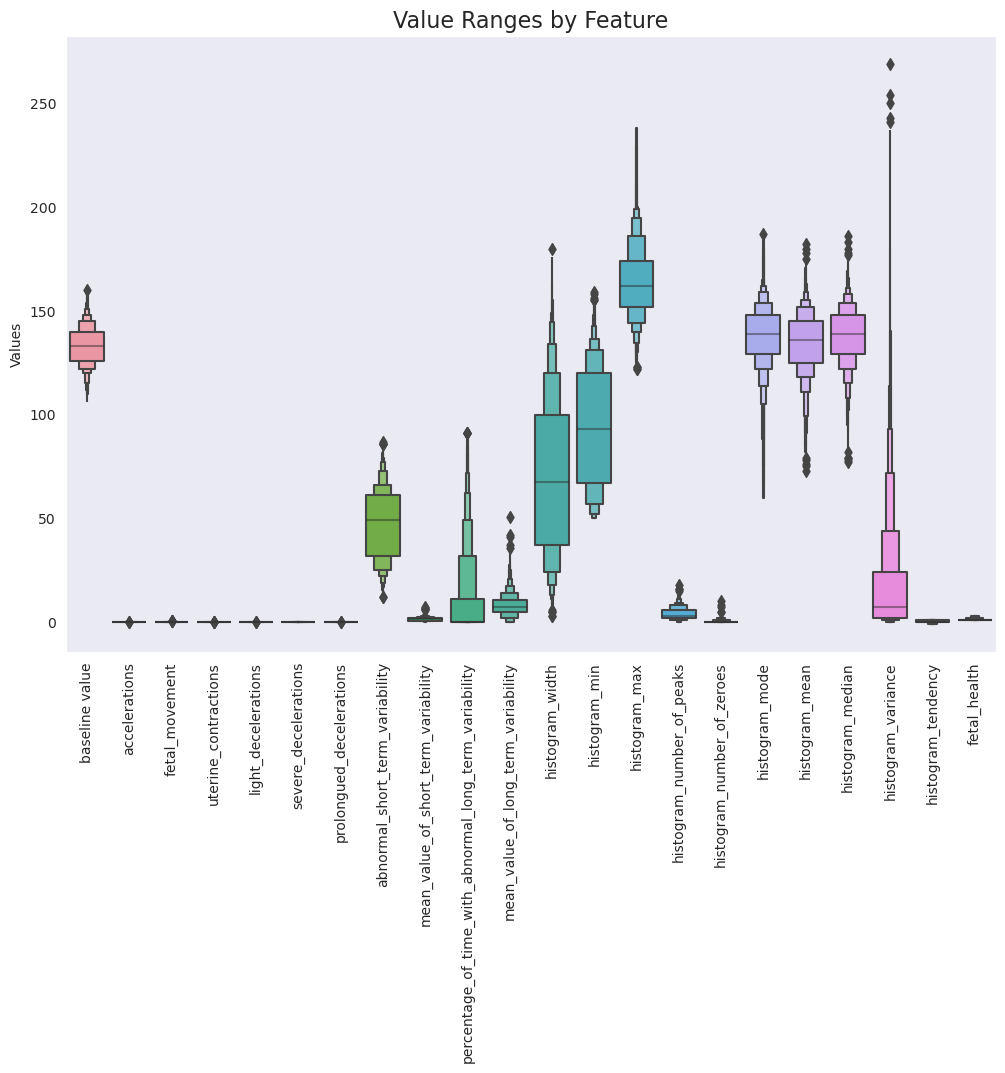

In [84]:
# Now we'll look at the ranges of each feature in our dataset.
plt.figure(figsize=(12,8))
sns.boxenplot(data=fetal_data)

# Titles
plt.title('Value Ranges by Feature', fontsize=16)
plt.ylabel('Values')
plt.xticks(rotation=90)

# Feature Scaling

Feature scaling is a critical step in preprocessing data that is used to standardize the range of features or variables in a dataset. It's very important because many machine learning models assume that the input features have a similar scale or distribution. 

We can see that the features in our dataset all span across different ranges. Before we fit models here we will scale our features. 

In [85]:
from sklearn.preprocessing import StandardScaler

col_order = list(X.columns)

scale_X = StandardScaler()
X_df = scale_X.fit_transform(X)
X = pd.DataFrame(X_df, columns=col_order)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'baseline value'),
  Text(1, 0, 'accelerations'),
  Text(2, 0, 'fetal_movement'),
  Text(3, 0, 'uterine_contractions'),
  Text(4, 0, 'light_decelerations'),
  Text(5, 0, 'severe_decelerations'),
  Text(6, 0, 'prolongued_decelerations'),
  Text(7, 0, 'abnormal_short_term_variability'),
  Text(8, 0, 'mean_value_of_short_term_variability'),
  Text(9, 0, 'percentage_of_time_with_abnormal_long_term_variability'),
  Text(10, 0, 'mean_value_of_long_term_variability'),
  Text(11, 0, 'histogram_width'),
  Text(12, 0, 'histogram_min'),
  Text(13, 0, 'histogram_max'),
  Text(14, 0, 'histogram_number_of_peaks'),
  Text(15, 0, 'histogram_number_of_zeroes'),
  Text(16, 0, 'histogram_mode'),
  Text(17, 0, 'histogram_mean'),
  Text(18, 0, 'histogram_median'),
  Text(19, 0, 'histogram_variance'),
  Text(20, 0, 'histogram_tendency')])

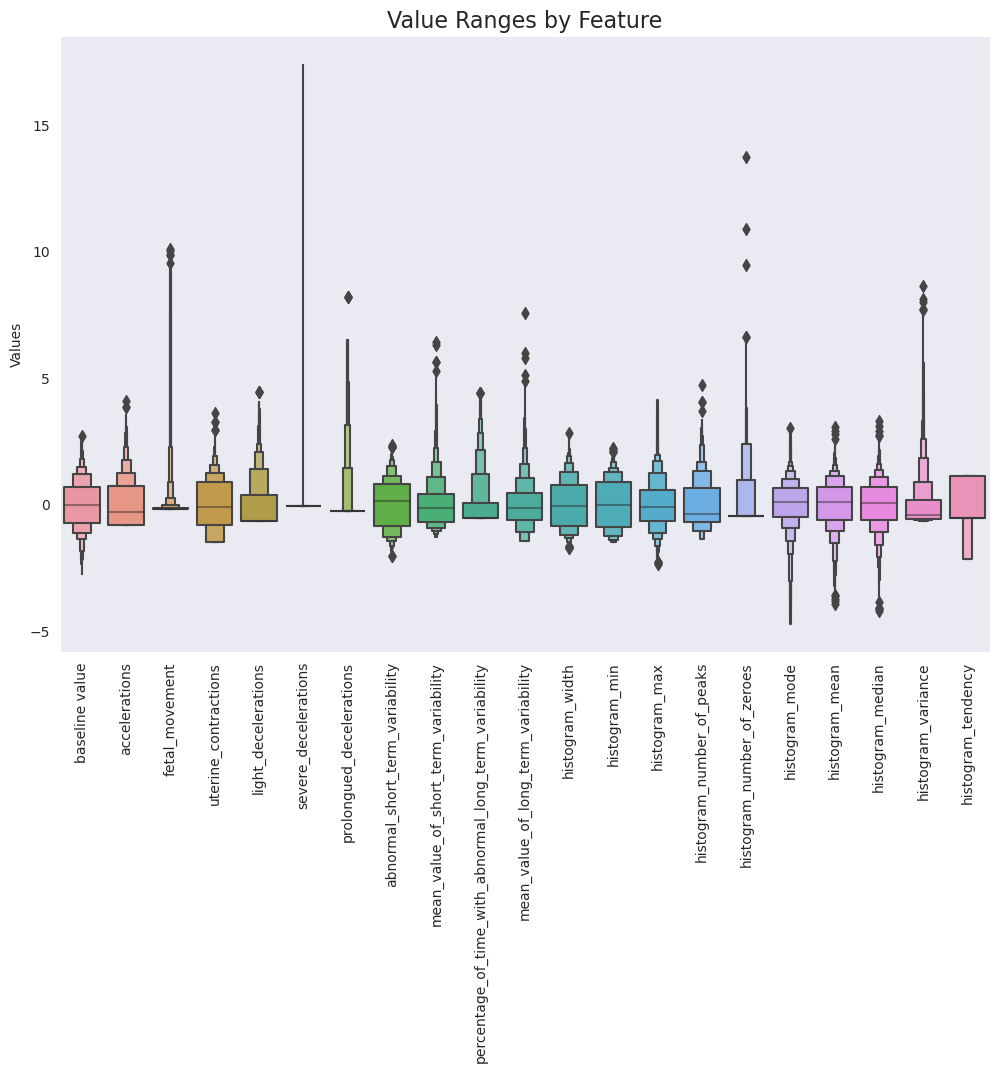

In [86]:
plt.figure(figsize=(12,8))
sns.boxenplot(data=X)

# Titles
plt.title('Value Ranges by Feature', fontsize=16)
plt.ylabel('Values')
plt.xticks(rotation=90)

In [87]:
# Now we'll split our data into training and test sets for validating our models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    test_size=0.2, random_state=0)

# **Modeling**
**Here we'll define and test 4 separate machine learning algorithms for making classifications with this dataset.**

The algorithms we'll use on this dataset are:

0. LogisticRegression (Baseline Model)
1. RandomForestClassifier
2. KNeighborsClassifer
3. SVC

First we'll define four pipelines and perform cross-validation to get an overview of how each algorithm performs against our baseline logistic regression model. Then we will perform grid search cross-validation on each algorithm to select hyperparameters and explore each model's performance in finer grain. 

# Cross-Validation

In [88]:
# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Pipelines
from sklearn.pipeline import Pipeline

# Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix

In [89]:
# LogisticRegression pipeline
lr_pipeline = Pipeline([('lr_classifier', LogisticRegression(random_state=0))])

# RandomForestClassifier pipeline
forest_pipeline = Pipeline([('rf_classifier', RandomForestClassifier(random_state=0))])

# KNeighborsClassifier pipeline
knn_pipeline = Pipeline([('knn_classifier', KNeighborsClassifier())])

# SVC pipeline
svc_pipeline = Pipeline([('sv_classifier', SVC())])

# List of our pipelines
pipelines = [lr_pipeline, forest_pipeline, knn_pipeline, svc_pipeline]

# Dictionary of our pipelines and their model types 
pipe_map = {0: 'LogisticRegression', 1: 'RandomForestClassifier', 2: 'KNeighborsClassifier', 
           3: 'SVC'}

# We'll fit each pipeline
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# And we'll run a cursory cross-validation analysis on each one to get an overview of their performance
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, cv=10)
    print(f'{pipe_map[i]}: {cv_score.mean()}')


LogisticRegression: 0.891764705882353
RandomForestClassifier: 0.9447058823529412
KNeighborsClassifier: 0.9058823529411765
SVC: 0.9123529411764707


In [90]:
accuracies = []
maes = []

# Grid Search Cross-Validation

Grid search cross-validation exhaustively searches for the best combination of hyperparameters from a specified range of values by performing a grid search. For each combination of hyperparameters, it trains a model using cross-validation, evaluates the performance of the model, and records the performance metric. It then selects the set of hyperparameter values that garnered the best performance, which we can then use. 

We'll perform grid search cross-validation experiments on each of our models and then evaluate the their performance in classifying fetal health states.

**1) RandomForestClassifier**. 

It's well established that both decision trees and random forests perform well when making classifications on clinical observations, particularly in this case where our data has been annotated by medical experts. Here we're primarily interested in modeling these experts' clinical decision making. 

We'll grid search across the **n_estimators, max_features, max_depth, criterion,** and **n_jobs hyperparameters.**

In [91]:
%%time
forest_parameters = {'n_estimators': [50, 100, 150, 200, 300, 500],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth': [4, 6, 8, 12, 14, 16, 18, None],
                    'criterion': ['gini', 'entropy'],
                    'n_jobs': [-1, 1, None]}

# Run our cross-validation grid search to optimize hyperparameters
forest_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=forest_parameters, 
                        cv=5, verbose=1)
forest_cv.fit(X_train, y_train)

# Extract the best hyperparameters found in our grid search
forest_cv.best_params_

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: user 41min 38s, sys: 55.3 s, total: 42min 33s
Wall time: 46min 31s


{'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'n_jobs': -1}

In [92]:
# We'll now evaluate a RandomForestClassifier with these parameters
forest_model = RandomForestClassifier(**forest_cv.best_params_)
forest_model.fit(X_train, y_train)
predictions = forest_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

accuracies.append(accuracy)
maes.append(mae)

print(f'{forest_model} accuracy: {accuracy}')
print(f'{forest_model} MAE: {mae}')

RandomForestClassifier(max_depth=18, max_features='sqrt', n_jobs=-1) accuracy: 0.9460093896713615
RandomForestClassifier(max_depth=18, max_features='sqrt', n_jobs=-1) MAE: 0.05868544600938967


In [93]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       326
         2.0       0.84      0.79      0.81        58
         3.0       0.95      0.90      0.93        42

    accuracy                           0.95       426
   macro avg       0.92      0.89      0.90       426
weighted avg       0.95      0.95      0.95       426



([<matplotlib.axis.YTick at 0x7bbc56d16710>,
 [Text(0, 0.5, 'Normal'),
  Text(0, 1.5, 'Suspect'),
  Text(0, 2.5, 'Pathological')])

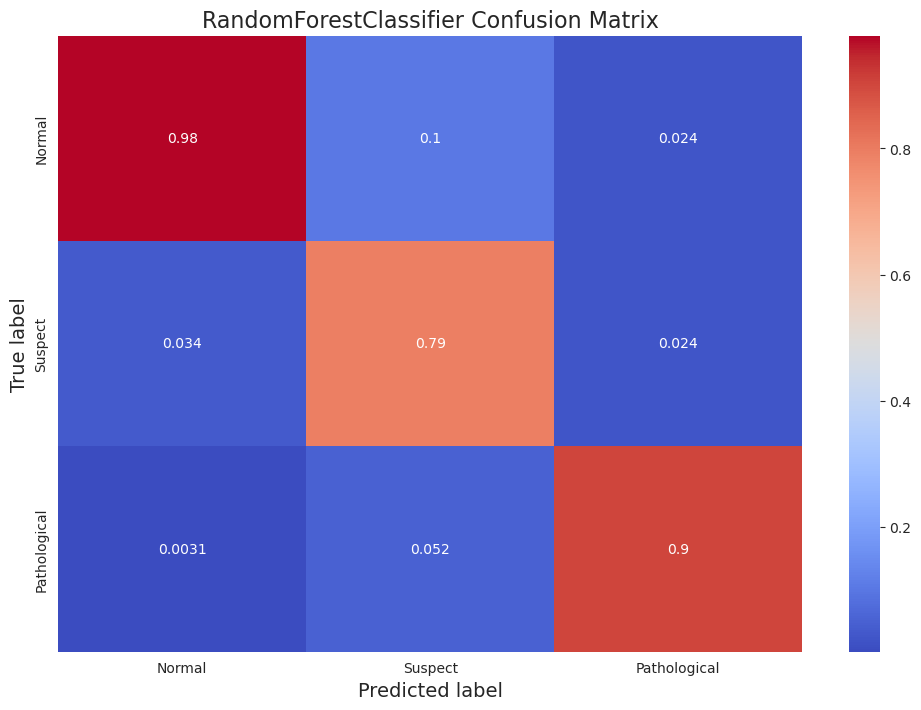

In [94]:
# Confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(data=cf_matrix.astype('float')/cf_matrix.sum(axis=1), cmap='coolwarm', annot=True)

# Titles
plt.title('RandomForestClassifier Confusion Matrix', fontsize=16)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.xticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathological'])
plt.yticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathological'])

Our RandomForestClassifier garnered recall scores of Normal = 0.98, Suspect = 0.79, and Pathological = 0.90. 

This means that for all of the actual Normal, Suspect, and Pathological samples in our data, it was able to correctly identify 98% as Normal, 79% as Suspect, and 90% as Pathological.

Overall the RandomForestClassifier achieved 0.95 accuracy with a MAE score of 0.059.

**2) KNeighborsClassifier.**

The KNeighborsClassifier works by identifying the K nearest neighbors (data points) to a new input data point and classifying the new data point based on the majority class among the K neighbors.

What we want to determine here is whether to use weighted KNN, how many neighbors to use, and what distance metric to use - we'll be grid searching across our **n_neighbors, weights,** and **p hyperparameters**.


In [95]:
%%time
knn_parameters = {'n_neighbors': [2, 3, 4, 5, 10, 15, 20],
                 'weights': ['uniform', 'distance'],
                 'p': [2, 1]}

# Run our cross-validation grid search to optimize hyperparameters
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_parameters, 
                        cv=5, verbose=1)
knn_cv.fit(X_train, y_train)

# Extract the best hyperparameters found in our grid search
knn_cv.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
CPU times: user 9.2 s, sys: 5.61 s, total: 14.8 s
Wall time: 5.35 s


{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [96]:
# We'll now evaluate a KNeighborsClassifier with these parameters
knn_model = KNeighborsClassifier(**knn_cv.best_params_)
knn_model.fit(X_train, y_train)
predictions = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

accuracies.append(accuracy)
maes.append(mae)

print(f'{knn_model} accuracy: {accuracy}')
print(f'{knn_model} MAE: {mae}')

KNeighborsClassifier(n_neighbors=4, p=1, weights='distance') accuracy: 0.9154929577464789
KNeighborsClassifier(n_neighbors=4, p=1, weights='distance') MAE: 0.09859154929577464


In [97]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       326
         2.0       0.75      0.72      0.74        58
         3.0       0.85      0.79      0.81        42

    accuracy                           0.92       426
   macro avg       0.85      0.83      0.84       426
weighted avg       0.91      0.92      0.91       426



([<matplotlib.axis.YTick at 0x7bbc717a8690>,
 [Text(0, 0.5, 'Normal'),
  Text(0, 1.5, 'Suspect'),
  Text(0, 2.5, 'Pathological')])

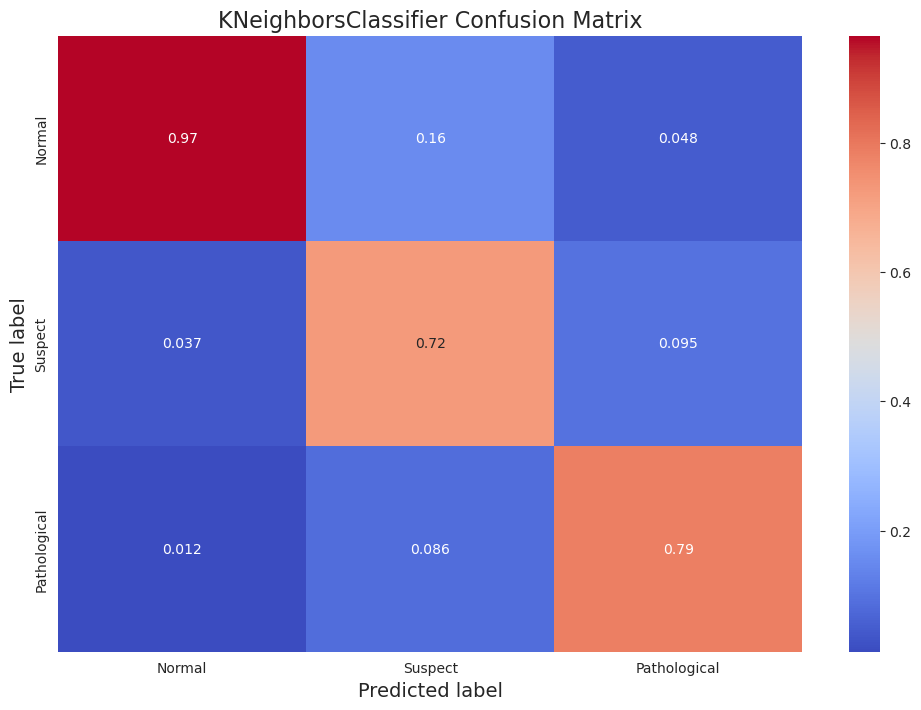

In [98]:
# Confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(data=cf_matrix.astype('float')/cf_matrix.sum(axis=1), cmap='coolwarm', annot=True)

# Titles
plt.title('KNeighborsClassifier Confusion Matrix', fontsize=16)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.xticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathological'])
plt.yticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathological'])

Our weighted KNeighborsClassifier attained recall scores of Normal = 0.97, Suspect = 0.72, and Pathological = 0.79. 

This means that for all of the actual Normal, Suspect, and Pathological samples in our data, it was able to correctly identify 97% as Normal, 72% as Suspect, and 79% as Pathological.

Overall the KNeighborsClassifier achieved 0.92 accuracy with a MAE score of 0.099. 

**3) SVC (Support Vector Classifier)**

A SVC works by finding the hyperplane that best separates the different classes in the input data, in order to create a decision boundary that maximizes the margin between the different classes. The decision boundary is defined by a subset of the input data points, known as support vectors. 

We'll grid search across the **kernel hyperparameter**.

In [99]:
%%time
svc_parameters = {'kernel': ['rbf', 'poly']}

# Run our cross-validation grid search to optimize hyperparameters
svc_cv = GridSearchCV(estimator=SVC(), param_grid=svc_parameters, 
                        cv=5, verbose=1)
svc_cv.fit(X_train, y_train)

# Extract the best hyperparameters found in our grid search
svc_cv.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 524 ms, sys: 1.95 ms, total: 526 ms
Wall time: 524 ms


{'kernel': 'rbf'}

In [100]:
# We'll now evaluate a SVC with these parameters
svc_model = SVC(**svc_cv.best_params_)
svc_model.fit(X_train, y_train)
predictions = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

accuracies.append(accuracy)
maes.append(mae)

print(f'{svc_model} accuracy: {accuracy}')
print(f'{svc_model} MAE: {mae}')

SVC() accuracy: 0.9014084507042254
SVC() MAE: 0.11502347417840375


In [101]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       326
         2.0       0.72      0.66      0.68        58
         3.0       0.91      0.74      0.82        42

    accuracy                           0.90       426
   macro avg       0.85      0.79      0.82       426
weighted avg       0.90      0.90      0.90       426



([<matplotlib.axis.YTick at 0x7bbc673e0d50>,
 [Text(0, 0.5, 'Normal'),
  Text(0, 1.5, 'Suspect'),
  Text(0, 2.5, 'Pathological')])

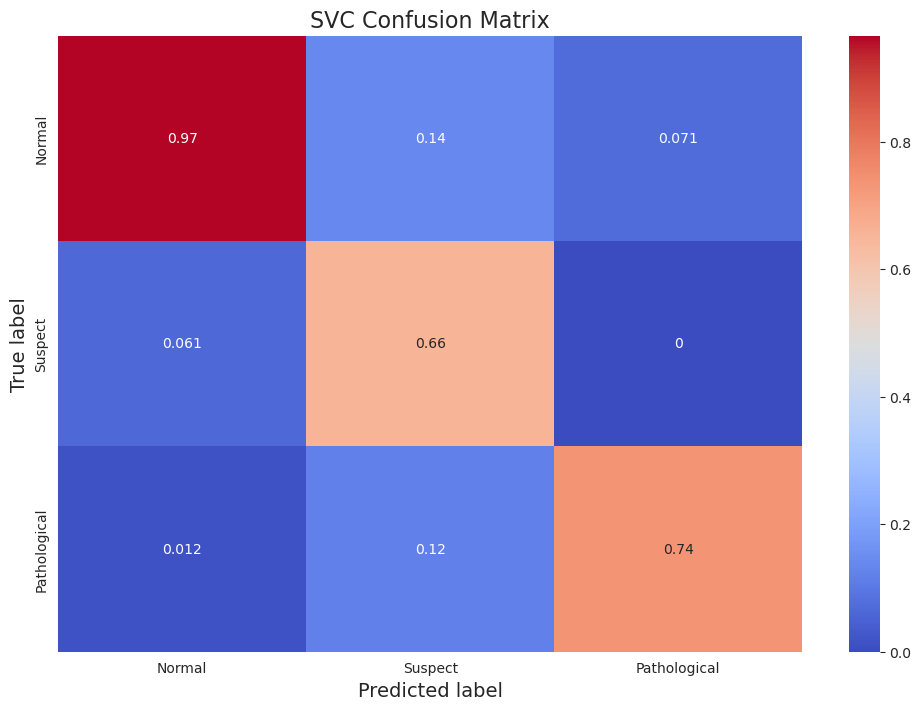

In [102]:
# Confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(data=cf_matrix.astype('float')/cf_matrix.sum(axis=1), cmap='coolwarm', annot=True)

# Titles
plt.title('SVC Confusion Matrix', fontsize=16)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.xticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathological'])
plt.yticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathological'])

Our SVC obtained recall scores of Normal = 0.97, Suspect = 0.66, and Pathological = 0.74.

This means that for all of the actual Normal, Suspect, and Pathological samples in our data, it was able to correctly identify 97% as Normal, 66% as Suspect, and 74% as Pathological.

Overall the SVC achieved 0.90 accuracy with a MAE score of 0.115.

[Text(0, 0, '0.946009'), Text(0, 0, '0.915493'), Text(0, 0, '0.901408')]

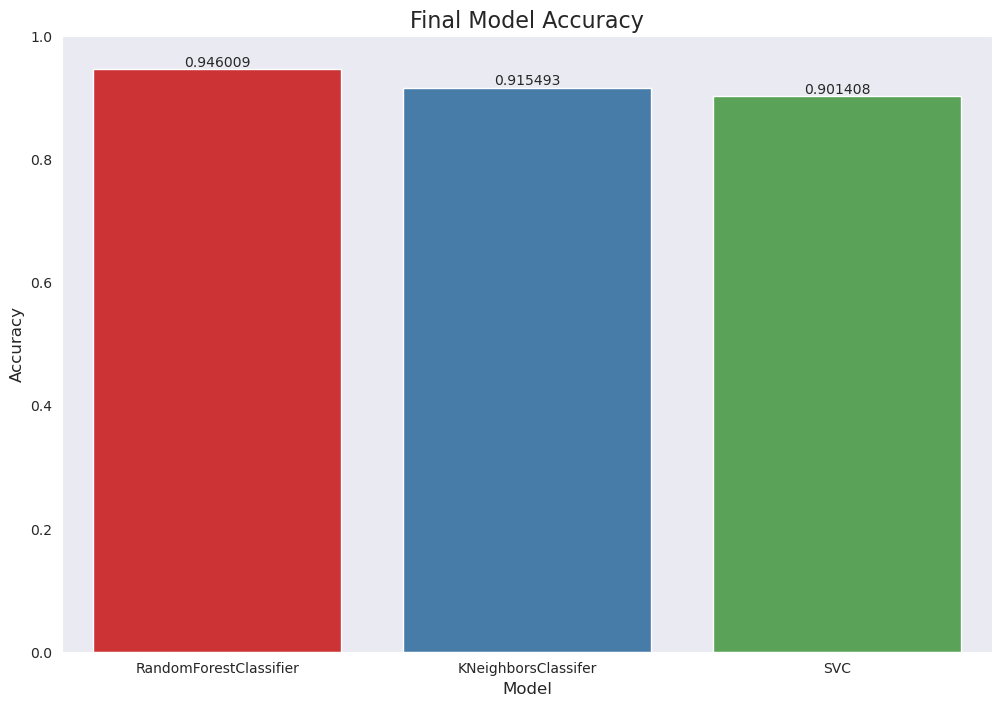

In [103]:
# Let's visualize our accuracy results
plt.figure(figsize=(12,8))
ax = sns.barplot(x=['RandomForestClassifier', 'KNeighborsClassifer', 'SVC'], 
                 y=accuracies, palette='Set1')

# Titles
plt.title('Final Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
ax.set_ylim((0, 1.0))
plt.xlabel('Model', fontsize=12)
ax.bar_label(ax.containers[0])

[Text(0, 0, '0.0586854'), Text(0, 0, '0.0985915'), Text(0, 0, '0.115023')]

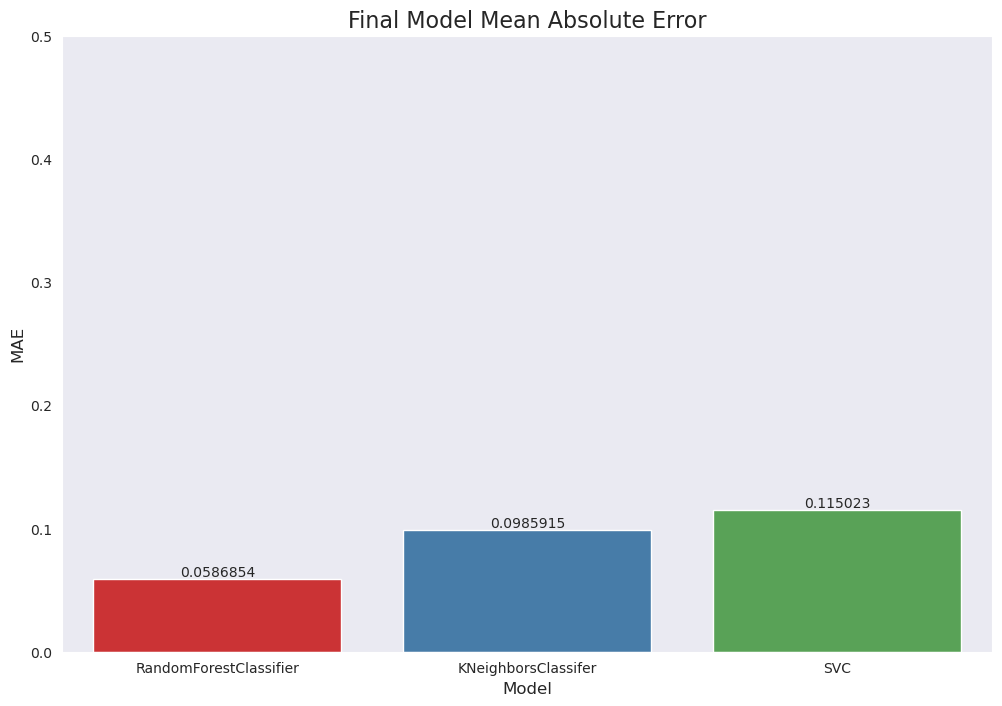

In [104]:
# We'll visualize our MAE results
plt.figure(figsize=(12,8))
ax = sns.barplot(x=['RandomForestClassifier', 'KNeighborsClassifer', 'SVC'], 
                 y=maes, palette='Set1')
# Titles
plt.title('Final Model Mean Absolute Error', fontsize=16)
plt.ylabel('MAE', fontsize=12)
ax.set_ylim((0, 0.5))
plt.xlabel('Model', fontsize=12)
ax.bar_label(ax.containers[0])

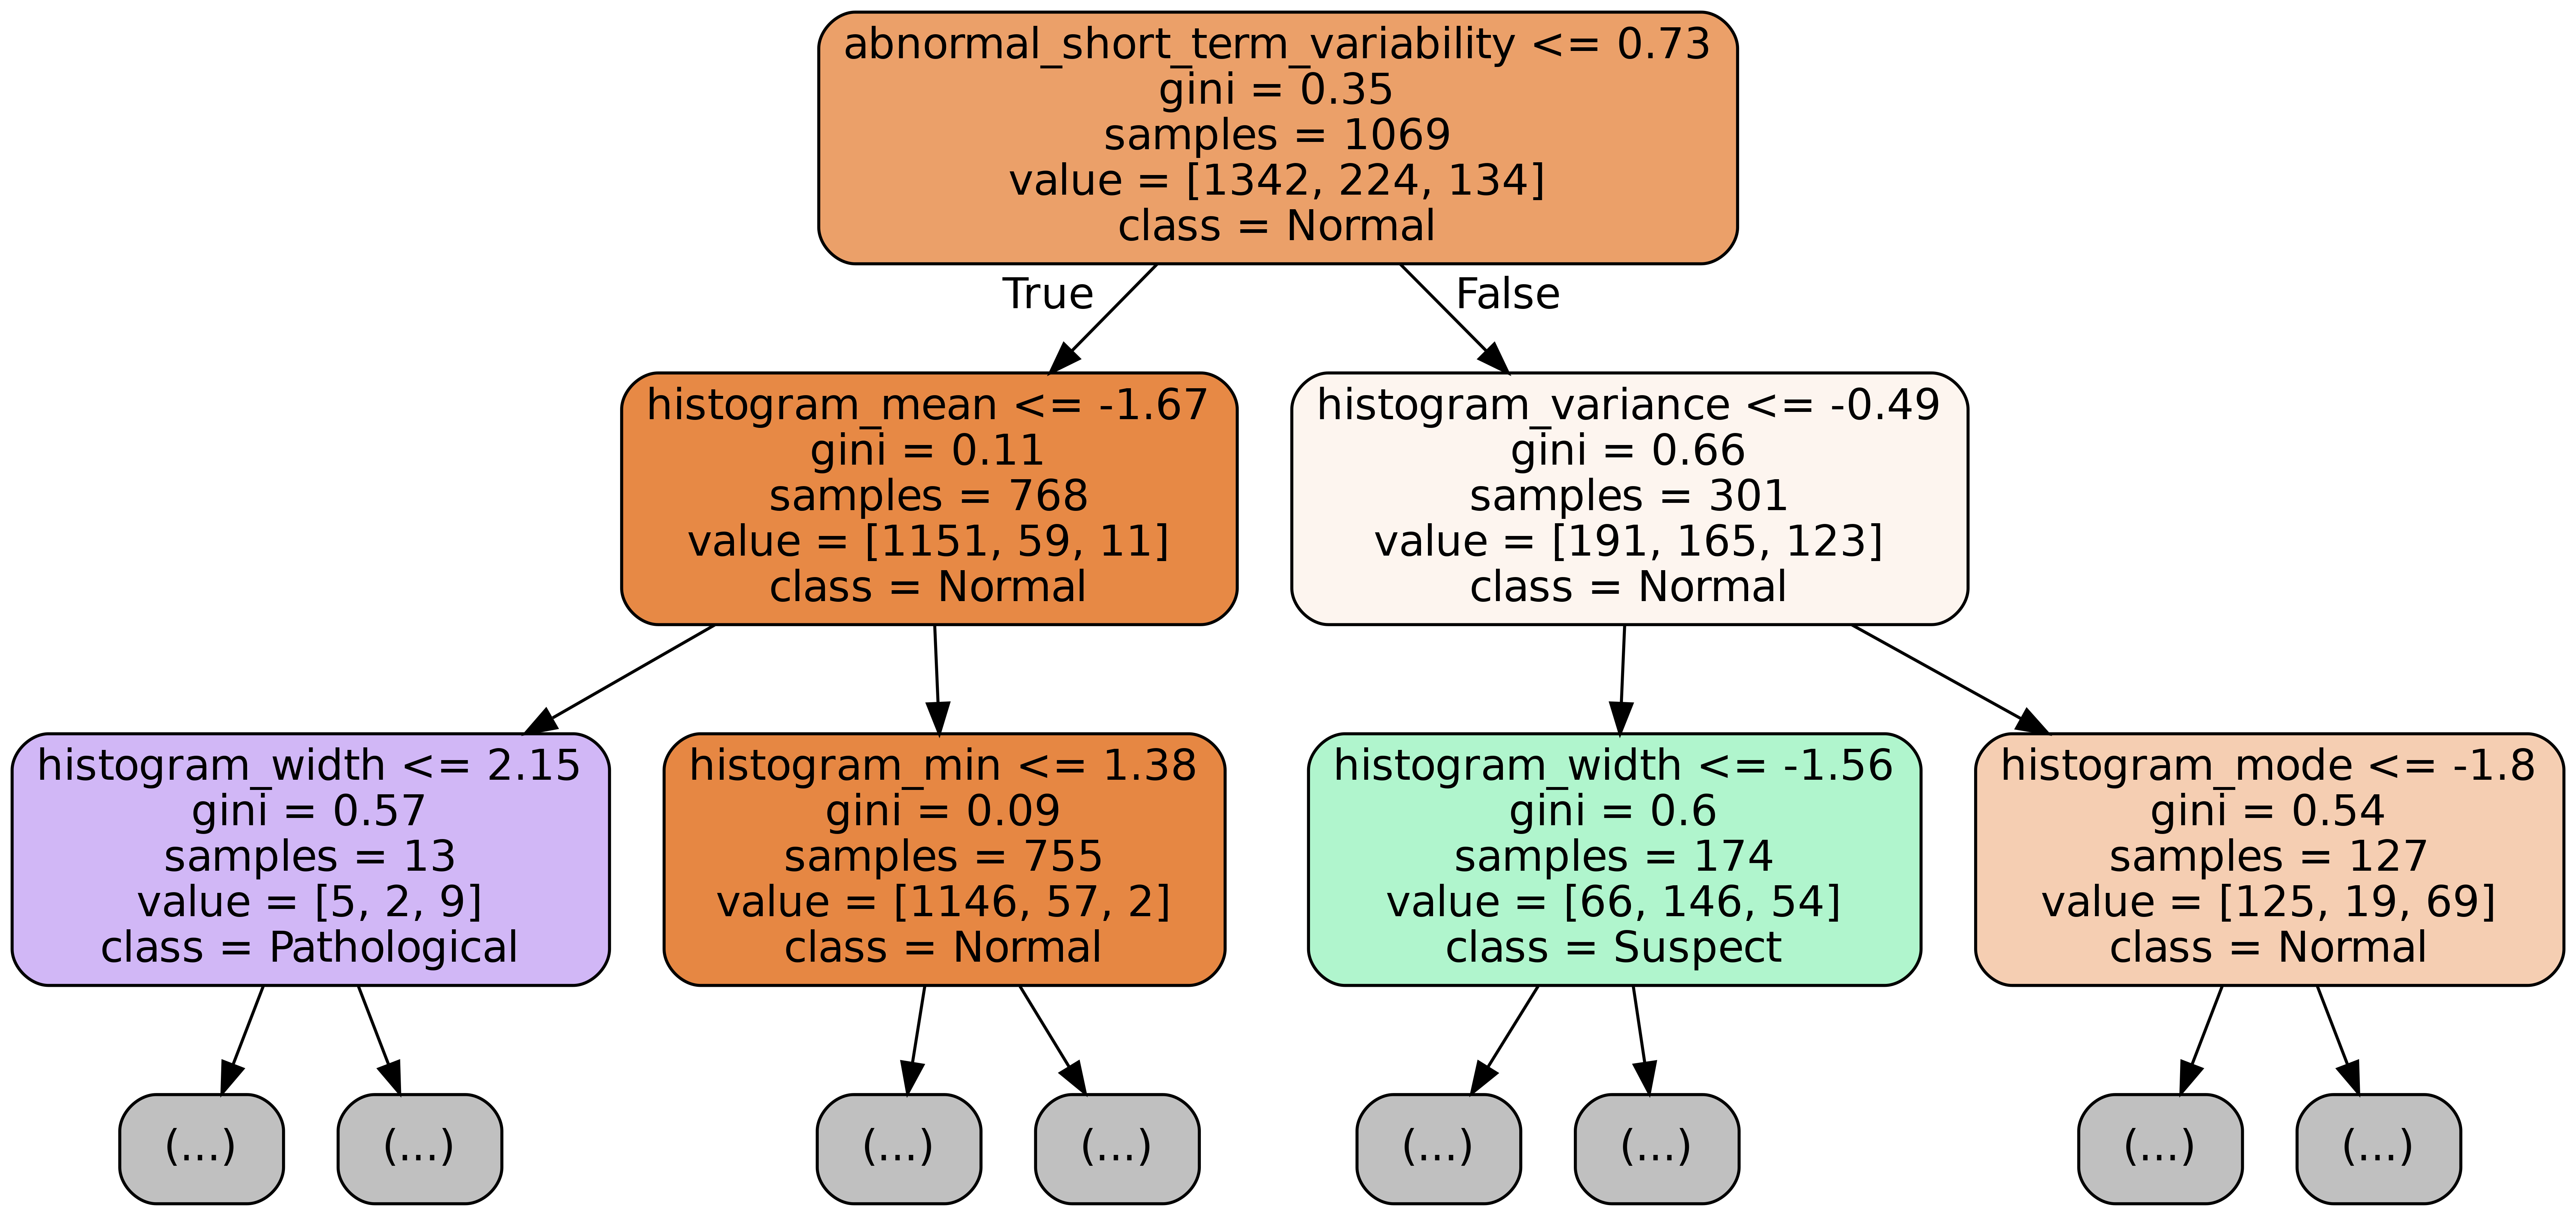

<Figure size 1600x1000 with 0 Axes>

In [107]:
# Finally, let's look at the top features in one of our random forest decision trees
from sklearn.tree import export_graphviz

estimator = forest_model.estimators_[5]
plt.figure(figsize=(16, 10))
classes = ['Normal', 'Suspect', 'Pathological']
export_graphviz(estimator, out_file='tree.dot', max_depth=2, 
                feature_names=X.columns,
                class_names=classes,
                rounded=True, proportion=False, 
                precision=2, filled=True)

# Convert to png file
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in Jupyter Notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Saving

We'll save our RandomForestClassifier model for future use because it was the best performing model on this dataset.

In [106]:
import pickle
with open('forest_model.pickle', 'wb') as f:
    pickle.dump(forest_model, f)

# **Conclusions:**

**The RandomForestClassifier performed best on this dataset.**

Using the information we empirically found in this analysis, along with the model that we've already trained, we can further develop tools that could be used to identify at risk fetuses during a birth event in real time. 

One incredibly useful property of random forests is that they push the most influential variables to the top of the tree. We could look for variables the random forest identified as having strong predictive power in classifying outcomes and specifically monitor adverse changes in those variables that might predict pathology in birth. A clinician could use this information to mobilize preventative measures before a full decomposition of patient health is actually reached.